In [3]:
%pip install xgboost lightgbm -q
%pip install scikit-learn xgboost lightgbm pandas seaborn matplotlib joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import joblib
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
models_dir = "../src/data/livrable_team1"
os.makedirs(models_dir, exist_ok=True)

base_train = pd.read_csv("../src/data/livrable_team1/team1_data_train.csv")
sentiment = pd.read_csv("../src/data/livrable_team1/telco_sentiment_enriched.csv")
topics_bert = pd.read_csv("../src/data/livrable_wadia/customer_feedback_with_topicsBert.csv")

print(base_train.columns)
print(sentiment.columns)
print(topics_bert.columns)


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'InternetService_fiber optic', 'InternetService_no',
       'Contract_one year', 'Contract_two year',
       'PaymentMethod_credit card (automatic)',
       'PaymentMethod_electronic check', 'PaymentMethod_mailed check'],
      dtype='object')
Index(['customerID', 'Churn', 'CustomerFeedback', 'sentiment_category',
       'cleaned_feedback', 'final_sentiment_score'],
      dtype='object')
Index(['customerID', 'Churn', 'CustomerFeedback', 'sentiment_category',
       'cleaned_feedback', 'final_sentiment_score', 'topic', 'topic_prob'],
      dtype='object')


In [5]:
# On garde ce qui sert vraiment du fichier sentiment
sentiment_small = sentiment[[
    "customerID",
    "sentiment_category",
    "final_sentiment_score"
]]

# On garde uniquement les infos de topic dans le fichier BERT
topics_small = topics_bert[[
    "customerID",
    "topic",
    "topic_prob"
]]


In [6]:
train_with_sent = base_train.merge(
    sentiment_small,
    on="customerID",
    how="left"
)

print(train_with_sent.shape)
train_with_sent.head()


(5625, 27)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,Churn,InternetService_fiber optic,InternetService_no,Contract_one year,Contract_two year,PaymentMethod_credit card (automatic),PaymentMethod_electronic check,PaymentMethod_mailed check,sentiment_category,final_sentiment_score
0,0292-wegch,1,0,1,1,0.746479,1,1,0,1,...,0,0,0,0,0,0,1,0,Very Positive,0.614189
1,7611-ykytc,0,0,1,1,0.295775,1,0,1,0,...,0,1,0,0,0,0,0,0,Very Positive,0.687113
2,3487-earat,1,0,1,1,0.971831,1,0,1,1,...,0,0,0,1,0,1,0,0,Very Positive,0.933506
3,1960-uycnn,0,0,0,0,0.126761,1,1,0,1,...,0,1,0,0,0,0,1,0,Very Positive,0.933344
4,6732-fzugp,1,0,0,0,0.647887,1,1,1,0,...,0,1,0,1,0,1,0,0,Very Positive,0.933524


In [7]:
train_hybrid = train_with_sent.merge(
    topics_small,
    on="customerID",
    how="left"
)

print(train_hybrid.shape)
train_hybrid.head()


(5625, 29)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_no,Contract_one year,Contract_two year,PaymentMethod_credit card (automatic),PaymentMethod_electronic check,PaymentMethod_mailed check,sentiment_category,final_sentiment_score,topic,topic_prob
0,0292-wegch,1,0,1,1,0.746479,1,1,0,1,...,0,0,0,0,1,0,Very Positive,0.614189,-1 internet service provider overall,0.00000
1,7611-ykytc,0,0,1,1,0.295775,1,0,1,0,...,0,0,0,0,0,0,Very Positive,0.687113,Transfer bank quality fast,1.00000
2,3487-earat,1,0,1,1,0.971831,1,0,1,1,...,0,1,0,1,0,0,Very Positive,0.933506,Card credit payments dsl,1.00000
3,1960-uycnn,0,0,0,0,0.126761,1,1,0,1,...,0,0,0,0,1,0,Very Positive,0.933344,Flexibility monthtomonth fast happy,0.71914
4,6732-fzugp,1,0,0,0,0.647887,1,1,1,0,...,0,1,0,1,0,0,Very Positive,0.933524,Credit card extremely fast,1.00000


In [9]:
train_hybrid.to_csv("../src/data/livrable_team3/team3_hybrid_train.csv", index=False)


In [10]:
# --- TEST HYBRIDE ---

base_test = pd.read_csv("../src/data/livrable_team1/team1_data_test.csv")

test_with_sent = base_test.merge(
    sentiment_small,
    on="customerID",
    how="left"
)

test_hybrid = test_with_sent.merge(
    topics_small,
    on="customerID",
    how="left"
)

print(test_hybrid.shape)
test_hybrid.head()

test_hybrid.to_csv("../src/data/livrable_team3/team3_hybrid_test.csv", index=False)


(1407, 29)


In [11]:
train_hybrid = pd.read_csv("../src/data/livrable_team3/team3_hybrid_train.csv")
test_hybrid  = pd.read_csv("../src/data/livrable_team3/team3_hybrid_test.csv")

print(train_hybrid.shape, test_hybrid.shape)
train_hybrid.head()


(5625, 29) (1407, 29)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_no,Contract_one year,Contract_two year,PaymentMethod_credit card (automatic),PaymentMethod_electronic check,PaymentMethod_mailed check,sentiment_category,final_sentiment_score,topic,topic_prob
0,0292-wegch,1,0,1,1,0.746479,1,1,0,1,...,0,0,0,0,1,0,Very Positive,0.614189,-1 internet service provider overall,0.00000
1,7611-ykytc,0,0,1,1,0.295775,1,0,1,0,...,0,0,0,0,0,0,Very Positive,0.687113,Transfer bank quality fast,1.00000
2,3487-earat,1,0,1,1,0.971831,1,0,1,1,...,0,1,0,1,0,0,Very Positive,0.933506,Card credit payments dsl,1.00000
3,1960-uycnn,0,0,0,0,0.126761,1,1,0,1,...,0,0,0,0,1,0,Very Positive,0.933344,Flexibility monthtomonth fast happy,0.71914
4,6732-fzugp,1,0,0,0,0.647887,1,1,1,0,...,0,1,0,1,0,0,Very Positive,0.933524,Credit card extremely fast,1.00000


In [12]:
df_train = train_hybrid.copy()
df_test  = test_hybrid.copy()

# --- 1) Remove categorical NLP (avoid leakage & ordinal distortion)
cols_to_remove = ["sentiment_category", "topic"]
df_train = df_train.drop(columns=[c for c in cols_to_remove if c in df_train.columns])
df_test  = df_test.drop(columns=[c for c in cols_to_remove if c in df_test.columns])

# --- 2) Keep only the clean numeric NLP features
numeric_nlp = ["final_sentiment_score", "topic_prob"]

for df in (df_train, df_test):
    for col in numeric_nlp:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

# --- 3) Remove non-predictive columns
cols_to_exclude = [
    "Churn",
    "customerID",
    "CustomerFeedback",
    "cleaned_feedback"
]

y_train = df_train["Churn"]
y_test  = df_test["Churn"]

X_train = df_train.drop(columns=cols_to_exclude, errors="ignore")
X_test  = df_test.drop(columns=cols_to_exclude, errors="ignore")

# --- 4) Convert to numeric cleanly
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0)
X_test  = X_test.apply(pd.to_numeric, errors="coerce").fillna(0)

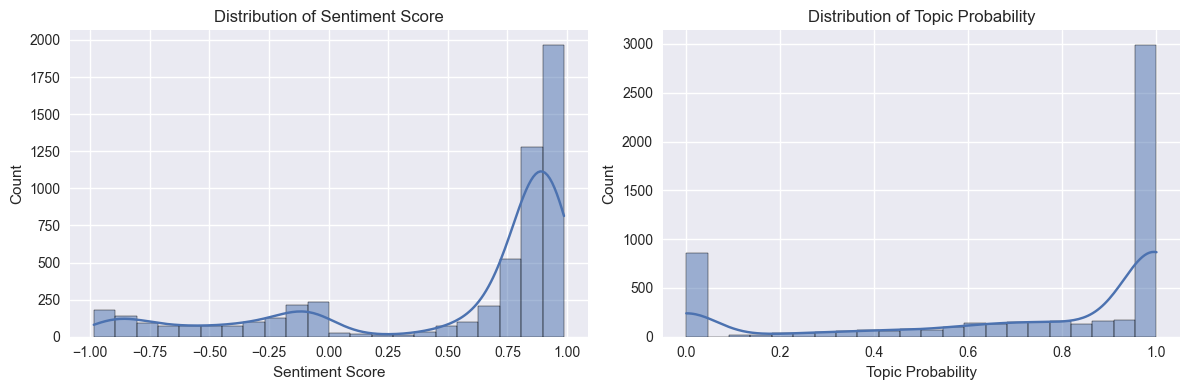

In [13]:
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Sentiment Score
sns.histplot(df_train["final_sentiment_score"], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Sentiment Score", fontsize=12)
axes[0].set_xlabel("Sentiment Score")

# --- Topic Probability
sns.histplot(df_train["topic_prob"], kde=True, ax=axes[1])
axes[1].set_title("Distribution of Topic Probability", fontsize=12)
axes[1].set_xlabel("Topic Probability")

plt.tight_layout()
plt.show()


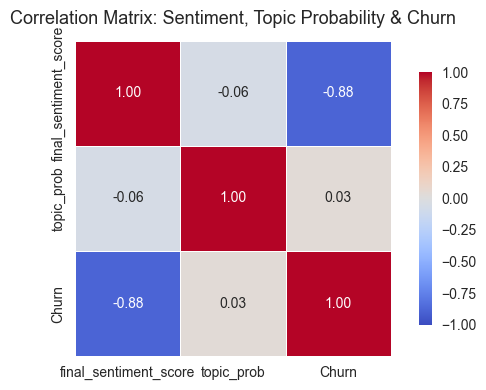

In [14]:
# --- Matrice de corrélation ciblée (sentiment – topic – churn)
corr_cols = ["final_sentiment_score", "topic_prob", "Churn"]
corr_matrix = df_train[corr_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap="coolwarm",
    square=True, linewidths=.5, cbar_kws={"shrink": .8}, fmt=".2f"
)

plt.title("Correlation Matrix: Sentiment, Topic Probability & Churn", fontsize=13, pad=12)
plt.tight_layout()
plt.show()


In [15]:
# ─────────────────────────
# 1) Dossier pour sauvegarder les modèles
# ─────────────────────────
models_dir = "../src/models/hybride"
os.makedirs(models_dir, exist_ok=True)

# ─────────────────────────
# 2) Gestion du déséquilibre (comme Team 1)
# ─────────────────────────
count_neg = int((y_train == 0).sum())
count_pos = int((y_train == 1).sum())
print("count_neg :", count_neg, "| count_pos :", count_pos)

scale_pos_weight = count_neg / count_pos if count_pos > 0 else 1.0
print(f"Ratio de déséquilibre (neg/pos) : {scale_pos_weight:.2f}\n")

# ─────────────────────────
# 3) Définition des modèles hybrides
# ─────────────────────────
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=100
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    ),
    "LightGBM": LGBMClassifier(
        scale_pos_weight=scale_pos_weight,
        verbosity=-1,
        random_state=42
    )
}


count_neg : 4130 | count_pos : 1495
Ratio de déséquilibre (neg/pos) : 2.76



In [16]:
# ───────────────────────────────────────────────
# 1) Définition des 3 scénarios
# ───────────────────────────────────────────────
scenarios = {
    "Sans_Sentiment": X_train.drop(columns=["final_sentiment_score"], errors="ignore"),
    "Sans_Topic": X_train.drop(columns=["topic_prob"], errors="ignore"),
    "Avec_2_Features": X_train  # toutes les features actuelles incluant sentiment + topic
}

results_scenarios = {}
print(" Démarrage du Benchmark (5 Modèles HYBRIDES)...\n")


# ───────────────────────────────────────────────
# 2) Boucle sur les 3 scénarios × 5 modèles
# ───────────────────────────────────────────────
for scenario_name, X_train_case in scenarios.items():

    print(f"\n===== Scenario : {scenario_name} =====")

    # Même transformation sur X_test
    X_test_case = X_test[X_train_case.columns]

    scenario_results = {}

    for name, model in models.items():

        print(f"Entraînement → {name}...")

        # Entraînement
        model.fit(X_train_case, y_train)

        # Prédictions
        y_pred = model.predict(X_test_case)
        y_prob = model.predict_proba(X_test_case)[:, 1]

        # Métriques
        auc = roc_auc_score(y_test, y_prob)
        accuracy = accuracy_score(y_test, y_pred)

        scenario_results[name] = {
            "AUC": auc,
            "Accuracy": accuracy
        }

        print(f"  AUC = {auc:.4f} | Accuracy = {accuracy:.4f}")

    results_scenarios[scenario_name] = scenario_results

# ───────────────────────────────────────────────
# 3) Tableau récapitulatif final
# ───────────────────────────────────────────────
summary = []

for scenario_name, models_res in results_scenarios.items():
    for model_name, metrics in models_res.items():
        summary.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "AUC": metrics["AUC"],
            "Accuracy": metrics["Accuracy"]
        })

df_summary = pd.DataFrame(summary)
print("\n===== RÉCAP FINAL : AUC & Accuracy par Scénario =====\n")
print(df_summary.sort_values(["Scenario", "AUC"], ascending=[True, False]))


 Démarrage du Benchmark (5 Modèles HYBRIDES)...


===== Scenario : Sans_Sentiment =====
Entraînement → Logistic Regression...
  AUC = 0.8480 | Accuracy = 0.7541
Entraînement → Random Forest...
  AUC = 0.8522 | Accuracy = 0.8053
Entraînement → Gradient Boosting...
  AUC = 0.8649 | Accuracy = 0.8088
Entraînement → XGBoost...
  AUC = 0.8452 | Accuracy = 0.7775
Entraînement → LightGBM...
  AUC = 0.8615 | Accuracy = 0.7740

===== Scenario : Sans_Topic =====
Entraînement → Logistic Regression...
  AUC = 0.9914 | Accuracy = 0.9638
Entraînement → Random Forest...
  AUC = 0.9909 | Accuracy = 0.9730
Entraînement → Gradient Boosting...
  AUC = 0.9923 | Accuracy = 0.9744
Entraînement → XGBoost...
  AUC = 0.9900 | Accuracy = 0.9723
Entraînement → LightGBM...
  AUC = 0.9910 | Accuracy = 0.9716

===== Scenario : Avec_2_Features =====
Entraînement → Logistic Regression...
  AUC = 0.9914 | Accuracy = 0.9645
Entraînement → Random Forest...
  AUC = 0.9923 | Accuracy = 0.9758
Entraînement → Gradient Boost

In [17]:
# ───────────────────────────────────────────────
# 4) Sélection du meilleur scénario et du meilleur modèle
# ───────────────────────────────────────────────

# Trouver la ligne avec le meilleur AUC global
best_row = df_summary.loc[df_summary["AUC"].idxmax()]

best_scenario_name = best_row["Scenario"]
best_model_name = best_row["Model"]

print("\n===== MEILLEUR SCÉNARIO & MODÈLE =====")
print(f"Meilleur scénario : {best_scenario_name}")
print(f"Meilleur modèle   : {best_model_name}\n")

# Récupération du modèle ré-entraîné
best_model = models[best_model_name]

# Reconstruction de X_train et X_test selon le scénario gagnant
if best_scenario_name == "Sans_Sentiment":
    X_train_best = X_train.drop(columns=["final_sentiment_score"], errors="ignore")
    X_test_best = X_test[X_train_best.columns]

elif best_scenario_name == "Sans_Topic":
    X_train_best = X_train.drop(columns=["topic_prob"], errors="ignore")
    X_test_best = X_test[X_train_best.columns]

else:  # Avec_2_Features
    X_train_best = X_train
    X_test_best = X_test[X_train_best.columns]

# Ré-entraîner le modèle gagnant
best_model.fit(X_train_best, y_train)


===== MEILLEUR SCÉNARIO & MODÈLE =====
Meilleur scénario : Avec_2_Features
Meilleur modèle   : Gradient Boosting



,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


C:\Users\pc\AppData\Local\Temp\ipykernel_988\3073139497.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


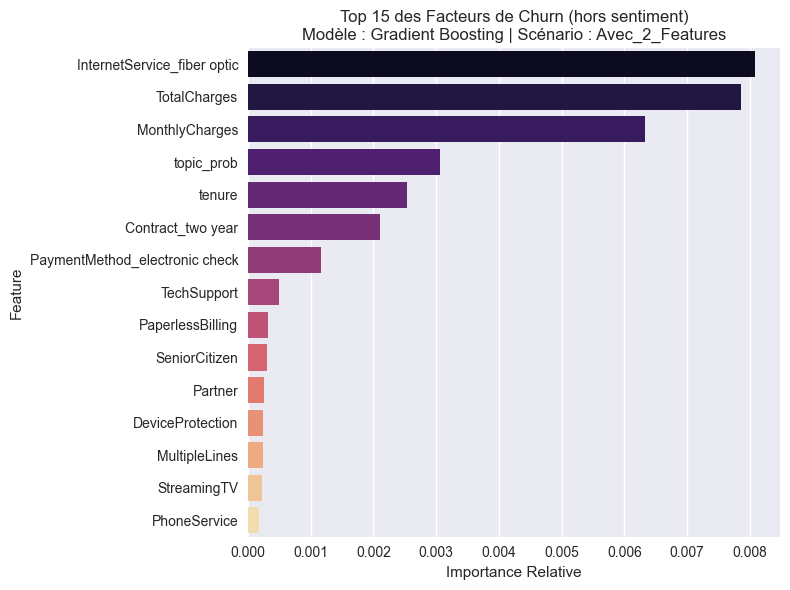

In [18]:
# ───────────────────────────────────────────────
# 5) Extraction + Visualisation des Importances
# ───────────────────────────────────────────────

# Extraction brute selon le type de modèle
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_

elif hasattr(best_model, "coef_"):
    importances = abs(best_model.coef_[0])

else:
    importances = [0] * len(X_train_best.columns)

feature_imp_df = pd.DataFrame({
    "Feature": X_train_best.columns,
    "Importance": importances
})

feature_imp_df = feature_imp_df[
    feature_imp_df["Feature"] != "final_sentiment_score"
]

# Tri décroissant
feature_imp_df = feature_imp_df.sort_values(by="Importance", ascending=False)

# Visualisation Top 15 hors sentiment
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_imp_df.head(15),
    palette="magma"
)
plt.title(f"Top 15 des Facteurs de Churn (hors sentiment)\nModèle : {best_model_name} | Scénario : {best_scenario_name}")
plt.xlabel("Importance Relative")
plt.tight_layout()
plt.show()


In [19]:
scenario_name = "Avec_2_Features"
X_train_case = scenarios[scenario_name]
X_test_case  = X_test[X_train_case.columns]

for model_name, model in models.items():
    # Réentraîner le modèle sur ce scénario
    model.fit(X_train_case, y_train)

    # Nom du fichier clair
    filename = f"model_{scenario_name}_{model_name.replace(' ', '_')}.pkl"
    filepath = os.path.join(models_dir, filename)

    # Sauvegarde avec joblib
    joblib.dump(model, filepath)

    print(f" Modèle sauvegardé : {filepath}")

 Modèle sauvegardé : ../src/models/hybride\model_Avec_2_Features_Logistic_Regression.pkl
 Modèle sauvegardé : ../src/models/hybride\model_Avec_2_Features_Random_Forest.pkl
 Modèle sauvegardé : ../src/models/hybride\model_Avec_2_Features_Gradient_Boosting.pkl
 Modèle sauvegardé : ../src/models/hybride\model_Avec_2_Features_XGBoost.pkl
 Modèle sauvegardé : ../src/models/hybride\model_Avec_2_Features_LightGBM.pkl
